In [1]:
# Load the dataset and inspect the head to make sure everything loaded correctly
import pandas as pd
df = pd.read_csv('Data/Stroke.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [2]:
# Check the data type of each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [3]:
# Check for class imbalance
print("Raw Counts:")
print(df['stroke'].value_counts())
print()
print('Percentages:')
print(df['stroke'].value_counts(normalize=True))

Raw Counts:
0    4861
1     249
Name: stroke, dtype: int64

Percentages:
0    0.951272
1    0.048728
Name: stroke, dtype: float64


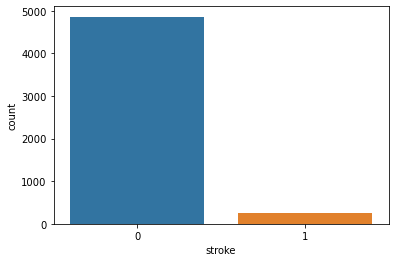

In [4]:
# Plot the distribution of values in column 'stroke'
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.countplot(df['stroke']);

In [5]:
# Check for missing values in the dataset
df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [6]:
# Fill in the missing values in 'bmi' column with mean value
df['bmi'] = df['bmi'].fillna(df.bmi.mean())
df['bmi'] = df['bmi'].round(decimals=1)
df.isna().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [7]:
# Look at the distibution of stroke among numerical features
df.groupby('stroke').mean()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi
stroke,,,,,,
0,36487.236371,41.971545,0.088871,0.047110,104.795513,28.825612
1,37115.068273,67.728193,0.265060,0.188755,132.544739,30.218876


In [8]:
"""The mean age of people with stroke is around 67 years, they more likely to have hypertension and heart disease, their average glucose level and bmi is higher"""

'The mean age of people with stroke is around 67 years, they more likely to have hypertension and heart disease, their average glucose level and bmi is higher'

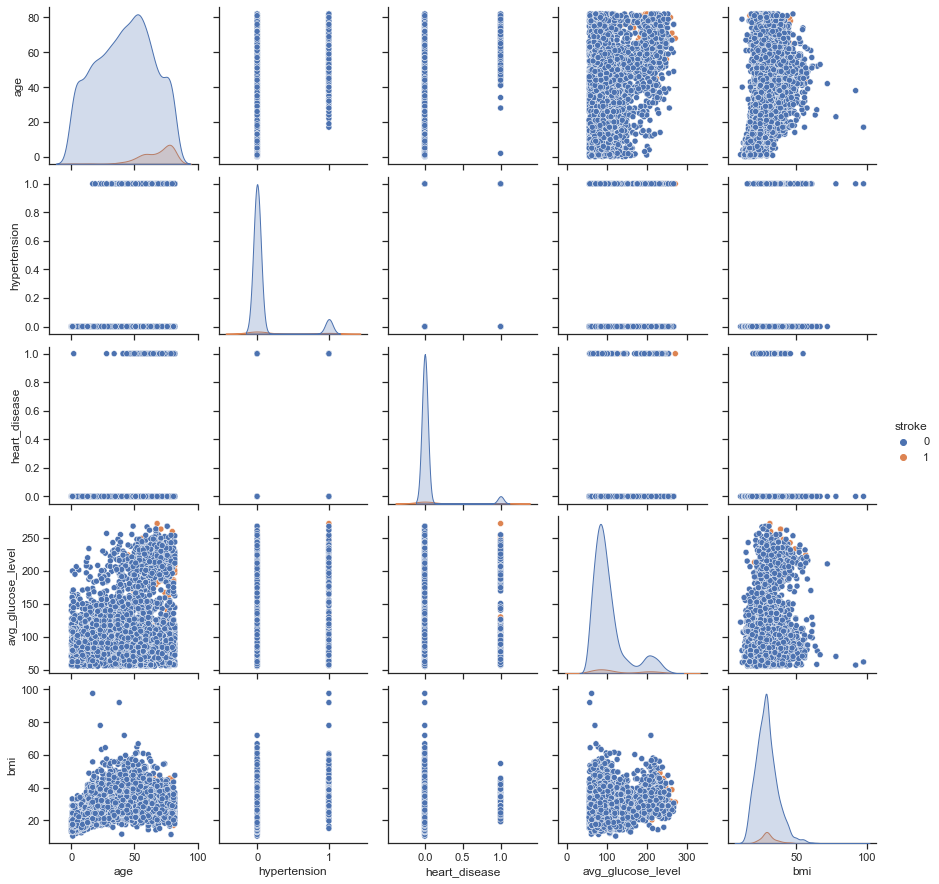

In [9]:
# Distribution of stroke among categorical features
sns.set(style = 'ticks', color_codes=True)
sns.pairplot(data=df, hue='stroke',  
             vars=['age',
                   'hypertension',
                   'heart_disease',
                   'avg_glucose_level',
                   'bmi']);

Percentage of Stroke Occurence Based on Gender:
gender
Female    4.709419
Male      5.106383
Other     0.000000
Name: stroke, dtype: float64



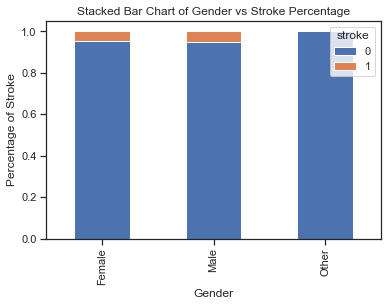

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

# Distribution of stroke based on gender
print("Percentage of Stroke Occurence Based on Gender:")
print(df.groupby('gender')['stroke'].mean() * 100)
print()
table = pd.crosstab(df.gender, df.stroke)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Gender vs Stroke Percentage')
plt.xlabel('Gender')
plt.ylabel('Percentage of Stroke')
plt.savefig('gender_vs_stroke')

Percentage of Stroke Occurence Based on Marital Status:
ever_married
No     1.650541
Yes    6.561288
Name: stroke, dtype: float64



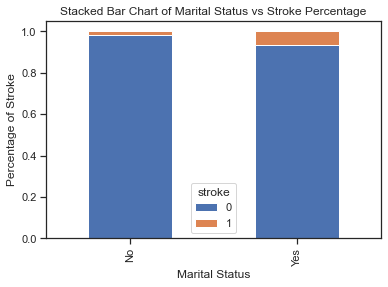

In [11]:
# Distribution of stroke based in marital status
print("Percentage of Stroke Occurence Based on Marital Status:")
print(df.groupby('ever_married')['stroke'].mean() * 100)
print()
table = pd.crosstab(df.ever_married, df.stroke)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Marital Status vs Stroke Percentage')
plt.xlabel('Marital Status')
plt.ylabel('Percentage of Stroke')
plt.savefig('marriage_vs_stroke')

Percentage of Stroke Occurence Based on Work Type:
work_type
Govt_job         5.022831
Never_worked     0.000000
Private          5.094017
Self-employed    7.936508
children         0.291121
Name: stroke, dtype: float64



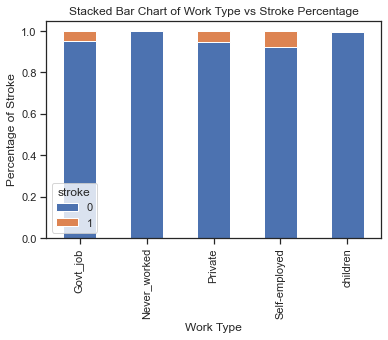

In [12]:
# Distribution of stroke based on work type
print("Percentage of Stroke Occurence Based on Work Type:")
print(df.groupby('work_type')['stroke'].mean() * 100)
print()
table = pd.crosstab(df.work_type, df.stroke)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Work Type vs Stroke Percentage')
plt.xlabel('Work Type')
plt.ylabel('Percentage of Stroke')
plt.savefig('work_vs_stroke')

Percentage of Stroke Occurence Based on Residence Type:
Residence_type
Rural    4.534606
Urban    5.200308
Name: stroke, dtype: float64



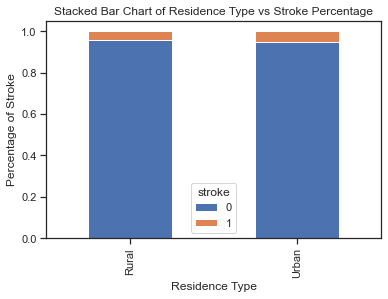

In [13]:
# Distribution of stroke based on residence type
print("Percentage of Stroke Occurence Based on Residence Type:")
print(df.groupby('Residence_type')['stroke'].mean() * 100)
print()
table = pd.crosstab(df.Residence_type, df.stroke)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Residence Type vs Stroke Percentage')
plt.xlabel('Residence Type')
plt.ylabel('Percentage of Stroke')
plt.savefig('residence_vs_stroke')

Percentage of Stroke Occurence Based on Smoking Status:
smoking_status
Unknown            3.044041
formerly smoked    7.909605
never smoked       4.756871
smokes             5.323194
Name: stroke, dtype: float64



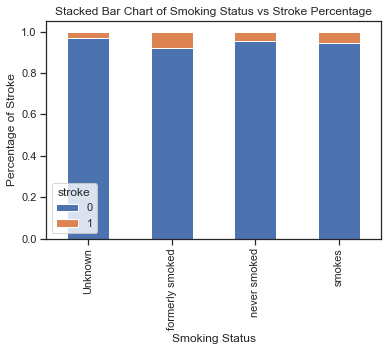

In [14]:
# Distribution of stroke based on smoking status
print("Percentage of Stroke Occurence Based on Smoking Status:")
print(df.groupby('smoking_status')['stroke'].mean() * 100)
print()
table = pd.crosstab(df.smoking_status, df.stroke)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Smoking Status vs Stroke Percentage')
plt.xlabel('Smoking Status')
plt.ylabel('Percentage of Stroke')
plt.savefig('smoking_vs_stroke')

In [15]:
"""As seen from the above charts, the parameters that influence on whether a person will have a stroke are: marital status, work type and smoking status"""

'As seen from the above charts, the parameters that influence on whether a person will have a stroke are: marital status, work type and smoking status'

In [16]:
# Transform the categorical variables into numerical 
df['gender'] = df['gender'].replace({'Female': 0, 'Male': 1, 'Other': 2}).astype('int8')
df['ever_married'] = df['ever_married'].replace({'No': 0, 'Yes': 1}).astype('int8')
df['Residence_type'] = df['Residence_type'].replace({'Urban': 0, 'Rural': 1}).astype('int8')

In [17]:
# Create dummy variables
df = pd.get_dummies(df, columns=['work_type', 'smoking_status'])
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,9046,1,67.0,0,1,1,0,228.69,36.6,1,0,0,1,0,0,0,1,0,0
1,51676,0,61.0,0,0,1,1,202.21,28.9,1,0,0,0,1,0,0,0,1,0
2,31112,1,80.0,0,1,1,1,105.92,32.5,1,0,0,1,0,0,0,0,1,0
3,60182,0,49.0,0,0,1,0,171.23,34.4,1,0,0,1,0,0,0,0,0,1
4,1665,0,79.0,1,0,1,1,174.12,24.0,1,0,0,0,1,0,0,0,1,0


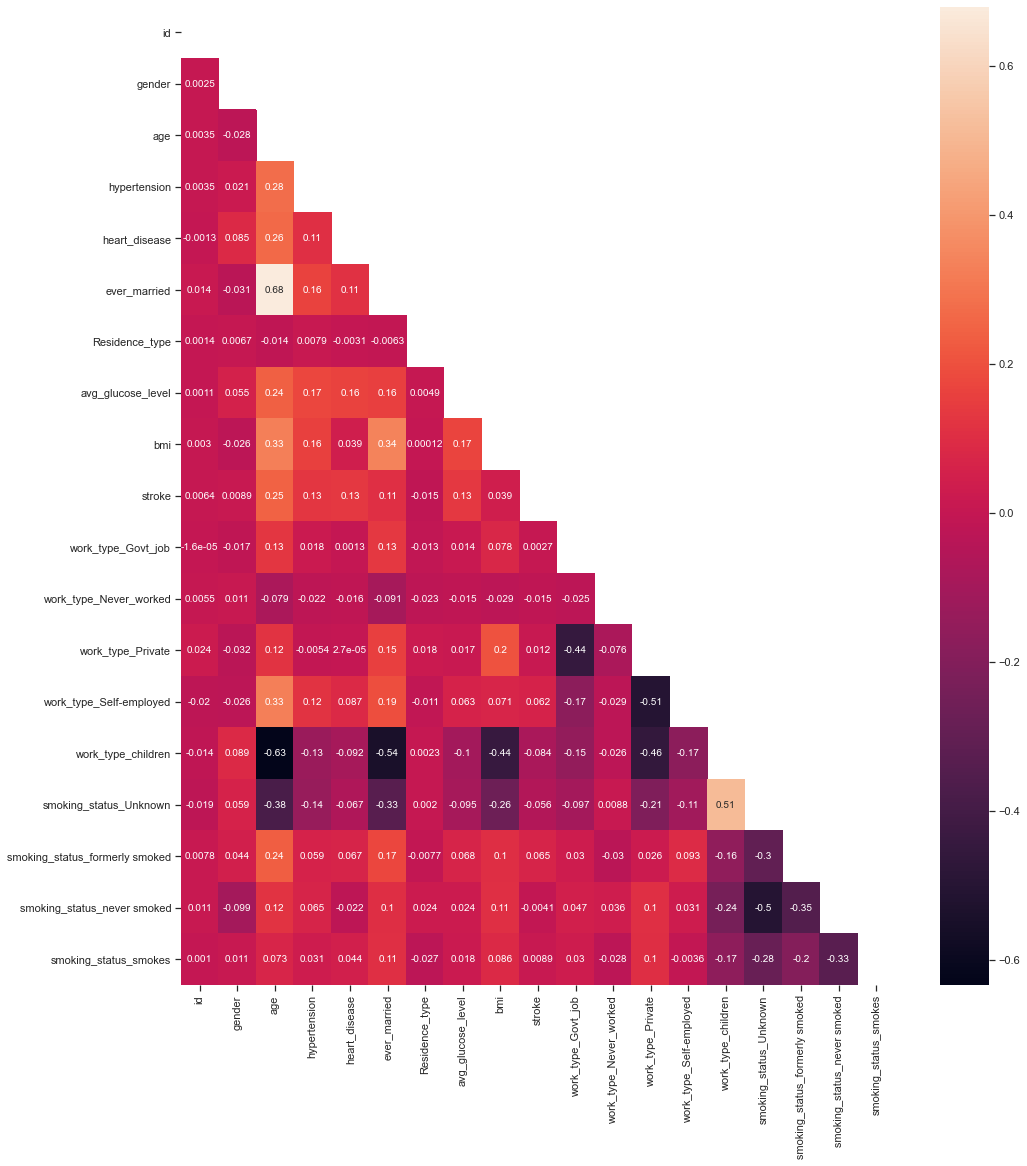

In [18]:
# Visualize the pearson correlation coefficients
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
corr = df.corr()
fig, ax = plt.subplots(figsize = (16, 18))
sns.heatmap(data = corr, 
            mask = np.triu(np.ones_like(corr, dtype = bool)), 
            ax = ax, 
            annot = True);

In [19]:
# Split the outcome and predictor variables
y = df['stroke']
X = df.drop(columns=['id', 'stroke'], axis=1)

In [20]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)
print(y_train.value_counts(),'\n\n', y_test.value_counts())

0    3645
1     187
Name: stroke, dtype: int64 

 0    1216
1      62
Name: stroke, dtype: int64


In [21]:
# Use SMOTE class to improve the model's performance on the minority class
from imblearn.over_sampling import SMOTE
smote = SMOTE()

# Preview the synthetic sample class distribution
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print(y_train_resampled.value_counts())

1    3645
0    3645
Name: stroke, dtype: int64


**Logistic Regression Models**

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Build a baseline model and find the average cross-validated log loss
logreg_baseline_model = LogisticRegression(random_state=42)
logreg_baseline_neg_log_loss_cv = -cross_val_score(
    logreg_baseline_model,
    X_train_resampled,
    y_train_resampled,
    scoring='neg_log_loss')
logreg_baseline_neg_log_loss_cv.mean()

0.19642809694087005

In [23]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

# Write the function that evaluates models on test sets
def print_metrics(labels, preds):
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("Precision Score: {}".format(precision_score(labels, preds)))
    print("Recall Score: {}".format(recall_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds)))

In [24]:
# Evaluate baseline model performance
logreg_baseline_model.fit(X_train_resampled, y_train_resampled)
preds = logreg_baseline_model.predict(X_test)
print("Logistic Regression Baseline Model:")
print_metrics(y_test, preds)

Logistic Regression Baseline Model:
Accuracy Score: 0.905320813771518
Precision Score: 0.2079207920792079
Recall Score: 0.3387096774193548
F1 Score: 0.25766871165644173


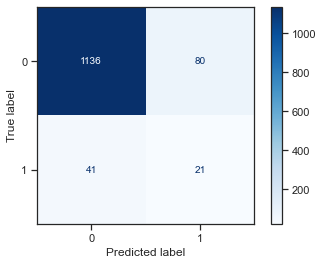

In [25]:
# Plot confusion matrix of the baseline model
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(logreg_baseline_model, X_test, y_test, cmap = plt.cm.Blues);

In [26]:
# Use the GridSerch to find better hyperparameters
from sklearn.model_selection import GridSearchCV
logreg_tuned = LogisticRegression(random_state=42)
param_grid = {'penalty' : ['l1', 'l2', 'elasticnet'],
              'solver' : ['liblinear', 'saga']}
    
grid_search = GridSearchCV(estimator = logreg_tuned,
                           param_grid = param_grid,
                           cv = 3)
grid_search.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=3, estimator=LogisticRegression(random_state=42),
             param_grid={'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['liblinear', 'saga']})

In [27]:
# Print the hyperparameters
grid_search.best_params_

{'penalty': 'l1', 'solver': 'liblinear'}

In [28]:
# Build a model with mentioned hyperparameters and find the average cross-validated log loss
logreg_tuned = LogisticRegression(random_state=42,
                                  penalty='l1',
                                  solver='liblinear')
logreg_tuned_neg_log_loss_cv = -cross_val_score(
    logreg_tuned,
    X_train_resampled,
    y_train_resampled,
    scoring='neg_log_loss')
logreg_log_loss = logreg_tuned_neg_log_loss_cv.mean()
logreg_log_loss

0.18621911099042757

In [29]:
# Evaluate the model's performance
logreg_tuned.fit(X_train_resampled, y_train_resampled)
preds = logreg_tuned.predict(X_test)
print("Logistic Regression Tuned Model:")
print_metrics(y_test, preds)

Logistic Regression Tuned Model:
Accuracy Score: 0.9225352112676056
Precision Score: 0.23943661971830985
Recall Score: 0.27419354838709675
F1 Score: 0.2556390977443609


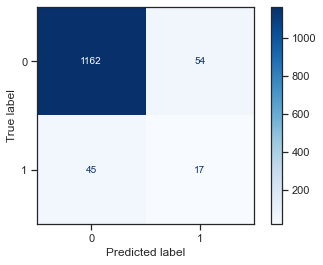

In [30]:
# Plot the confusion matrix 
plot_confusion_matrix(logreg_tuned, X_test, y_test, cmap = plt.cm.Blues);

**Decision Tree Models**

In [31]:
# Build a baseline model and find the average cross-validated log loss
from sklearn.tree import DecisionTreeClassifier
dt_baseline_model = DecisionTreeClassifier(random_state=42)
dt_baseline_model_neg_log_loss_cv = -cross_val_score(
    dt_baseline_model,
    X_train_resampled,
    y_train_resampled,
    scoring='neg_log_loss')
dt_baseline_model_neg_log_loss_cv.mean()

2.0420315674584044

In [32]:
# Evaluate the model's performance
dt_baseline_model.fit(X_train_resampled, y_train_resampled)
preds = dt_baseline_model.predict(X_test)
print("Decision Tree Baseline Model:")
print_metrics(y_test, preds)

Decision Tree Baseline Model:
Accuracy Score: 0.8959311424100157
Precision Score: 0.12631578947368421
Recall Score: 0.1935483870967742
F1 Score: 0.15286624203821655


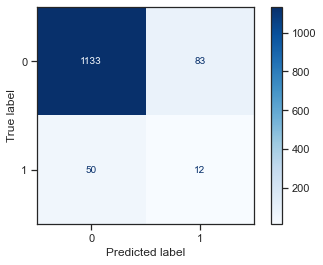

In [33]:
# Plot the confusion matrix
plot_confusion_matrix(dt_baseline_model, X_test, y_test, cmap = plt.cm.Blues);

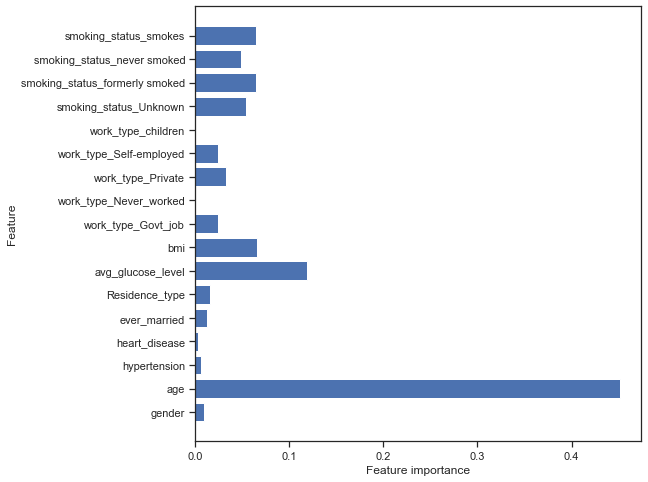

In [34]:
# Examine how important each feature ends up in the model
def plot_feature_importances(model):
    n_features = X_train_resampled.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), X_train_resampled.columns.values)
    plt.xlabel("Feature importance")
    plt.ylabel('Feature')
    
plot_feature_importances(dt_baseline_model)

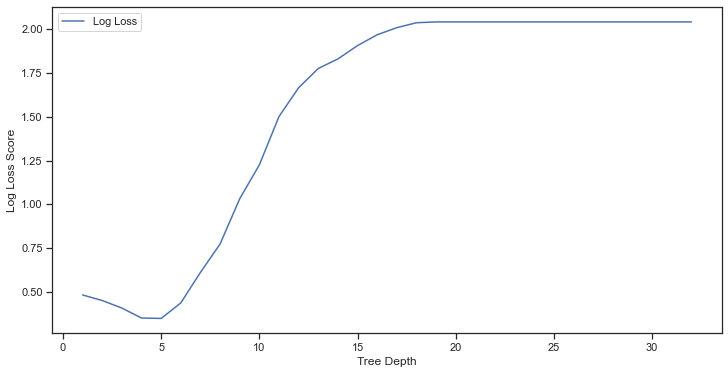

In [35]:
# Find the best tree depth using the range: 1-30
max_depths = np.linspace(1, 32, 32, endpoint=True)
log_loss_results = []
for max_depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    dt.fit(X_train_resampled, y_train_resampled)
    y_pred = dt.predict(X_test)
    dt_log_loss = cross_val_score(
        dt, 
        X_train_resampled,
        y_train_resampled,
        scoring='neg_log_loss')
    dtlog_loss = -(dt_log_loss.mean())
    log_loss_results.append(dtlog_loss)
    
plt.figure(figsize=(12,6))
plt.plot(max_depths, log_loss_results, label='Log Loss')
plt.ylabel('Log Loss Score')
plt.xlabel("Tree Depth")
plt.legend()
plt.show()

In [36]:
"""max depths of 4 is the best parameter"""

'max depths of 4 is the best parameter'

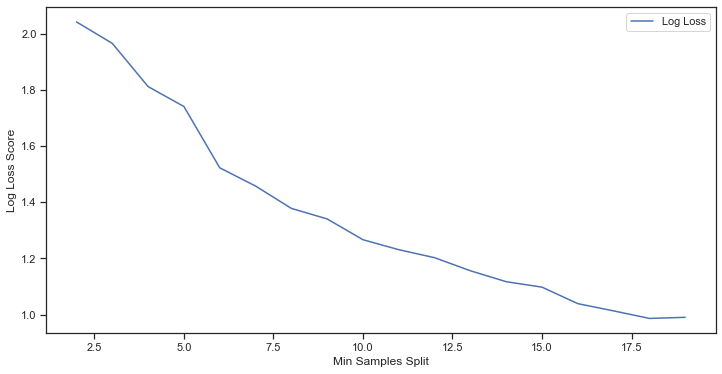

In [37]:
# Find the best min samples split
min_samples_splits = np.arange(2, 20)
log_loss_results = []
for min_samples_split in min_samples_splits:
    dt = DecisionTreeClassifier(
        min_samples_split=int(min_samples_split),
        random_state=42)
    dt.fit(X_train_resampled, y_train_resampled)
    y_pred = dt.predict(X_test)
    dt_log_loss = cross_val_score(
        dt, 
        X_train_resampled,
        y_train_resampled,
        scoring='neg_log_loss')
    dtlog_loss = -(dt_log_loss.mean())
    log_loss_results.append(dtlog_loss)
    
plt.figure(figsize=(12,6))
plt.plot(min_samples_splits, log_loss_results, label='Log Loss')
plt.ylabel('Log Loss Score')
plt.xlabel("Min Samples Split")
plt.legend()
plt.show()

In [38]:
"""min samples split of 18 is the best parameter"""

'min samples split of 18 is the best parameter'

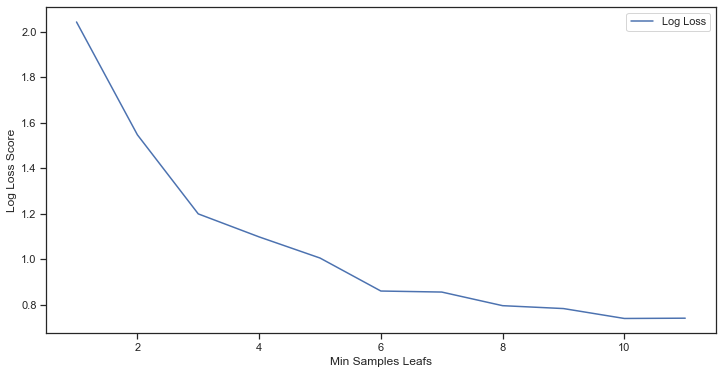

In [39]:
# Find the best min samples leafs
min_samples_leafs = np.arange(1, 12)
log_loss_results = []
for min_samples_leaf in min_samples_leafs:
    dt = DecisionTreeClassifier(
        min_samples_leaf=int(min_samples_leaf),
        random_state=42)
    dt.fit(X_train_resampled, y_train_resampled)
    y_pred = dt.predict(X_test)
    dt_log_loss = cross_val_score(
        dt, 
        X_train_resampled,
        y_train_resampled,
        scoring='neg_log_loss')
    dtlog_loss = -(dt_log_loss.mean())
    log_loss_results.append(dtlog_loss)
    
plt.figure(figsize=(12,6))
plt.plot(min_samples_leafs, log_loss_results, label='Log Loss')
plt.ylabel('Log Loss Score')
plt.xlabel("Min Samples Leafs")
plt.legend()
plt.show()

In [40]:
"""10 is the best parameter for min_samples_leafs"""

'10 is the best parameter for min_samples_leafs'

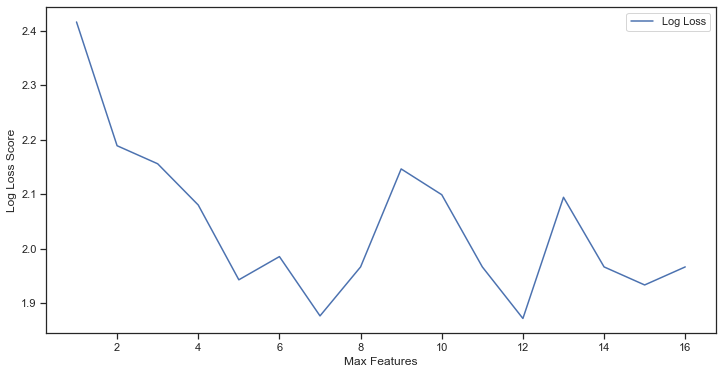

In [41]:
# Find best max features
max_features = list(range(1, X_train_resampled.shape[1]))
log_loss_results = []
for max_feature in max_features:
    dt = DecisionTreeClassifier(
        max_features=max_feature,
        random_state=42)
    dt.fit(X_train_resampled, y_train_resampled)
    y_pred = dt.predict(X_test)
    dt_log_loss = cross_val_score(
        dt, 
        X_train_resampled,
        y_train_resampled,
        scoring='neg_log_loss')
    dtlog_loss = -(dt_log_loss.mean())
    log_loss_results.append(dtlog_loss)
    
plt.figure(figsize=(12,6))
plt.plot(max_features, log_loss_results, label='Log Loss')
plt.ylabel('Log Loss Score')
plt.xlabel("Max Features")
plt.legend()
plt.show()

In [42]:
"""12 is the best parameter for max features"""

'12 is the best parameter for max features'

In [43]:
# Run an optimized model with the found values and find the average cross-validated log loss
dt_tuned = DecisionTreeClassifier(
    random_state=42,
    max_depth=4,
    min_samples_split=18,
    min_samples_leaf=10,
    max_features=12)
dt_tuned_neg_log_loss_cv = -cross_val_score(
    dt_tuned,
    X_train_resampled,
    y_train_resampled,
    scoring='neg_log_loss')
dt_log_loss = dt_tuned_neg_log_loss_cv.mean()
dt_log_loss

0.3959199245187137

In [45]:
# Check the model's performance
dt_tuned.fit(X_train_resampled, y_train_resampled)
preds = dt_tuned.predict(X_test)
print("Decision Tree Tuned Model:")
print_metrics(y_test, preds)

Decision Tree Tuned Model:
Accuracy Score: 0.837245696400626
Precision Score: 0.12755102040816327
Recall Score: 0.4032258064516129
F1 Score: 0.1937984496124031


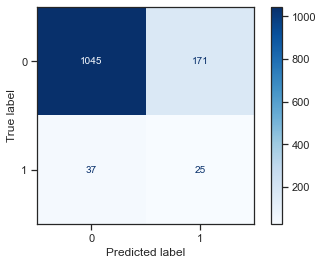

In [46]:
# Plot the confusion matrix
plot_confusion_matrix(dt_tuned, X_test, y_test, cmap = plt.cm.Blues);

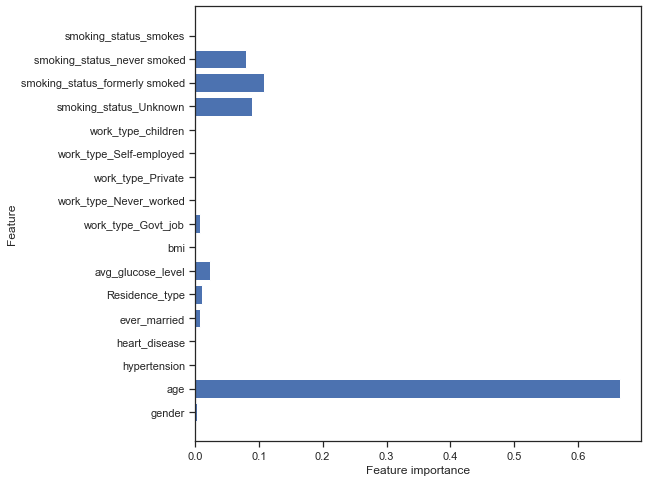

In [47]:
# Examine how important each feature is in the model
plot_feature_importances(dt_tuned)

**Bagged Trees Models**

In [48]:
from sklearn.ensemble import BaggingClassifier

# Build a baseline model with Bagging and find the average cross-validated log loss
# Set the n_estimators parameter to 100
bagged_tree_baseline = BaggingClassifier(DecisionTreeClassifier(random_state=42), n_estimators=100)
bagged_baseline_neg_log_loss_cv = -cross_val_score(
    bagged_tree_baseline,
    X_train_resampled,
    y_train_resampled,
    scoring='neg_log_loss')
bagged_baseline_neg_log_loss_cv.mean()

0.16324952069583493

In [49]:
# Evaluate the performance of the model
bagged_tree_baseline.fit(X_train_resampled, y_train_resampled)
preds = bagged_tree_baseline.predict(X_test)
print("Bagged Tree Baseline Model:")
print_metrics(y_test, preds)

Bagged Tree Baseline Model:
Accuracy Score: 0.9287949921752738
Precision Score: 0.17777777777777778
Recall Score: 0.12903225806451613
F1 Score: 0.14953271028037382


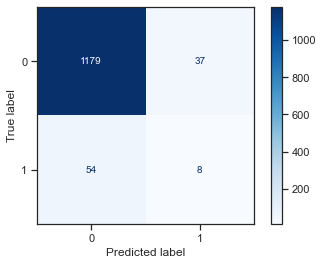

In [50]:
# Plot the confusion matrix
plot_confusion_matrix(bagged_tree_baseline, X_test, y_test, cmap = plt.cm.Blues);

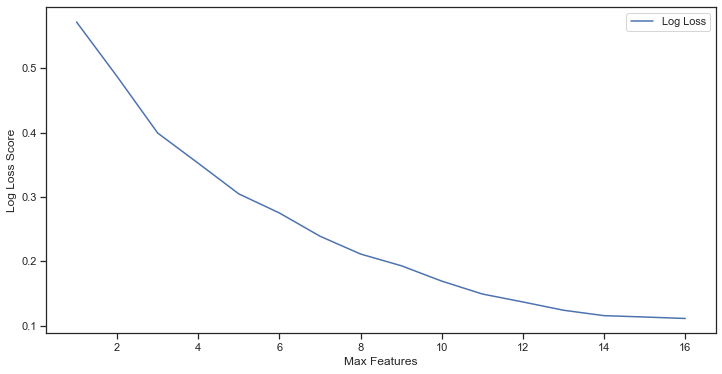

In [51]:
# Find the best value for max features
max_features = list(range(1, X_train_resampled.shape[1]))
log_loss_results = []
for max_feature in max_features:
    bagged = BaggingClassifier(DecisionTreeClassifier(random_state=42),
                                    n_estimators=100,
                                    max_features=max_feature)
    bagged.fit(X_train_resampled, y_train_resampled)
    y_pred = bagged.predict(X_test)
    bagged_log_loss = cross_val_score(
        bagged, 
        X_train_resampled,
        y_train_resampled,
        scoring='neg_log_loss')
    baggedlog_loss = -(bagged_log_loss.mean())
    log_loss_results.append(baggedlog_loss)
    
plt.figure(figsize=(12,6))
plt.plot(max_features, log_loss_results, label='Log Loss')
plt.ylabel('Log Loss Score')
plt.xlabel("Max Features")
plt.legend()
plt.show()

In [52]:
# Run the model with tuned hyperparameter
bagged_tree_tuned = BaggingClassifier(DecisionTreeClassifier(random_state=42), n_estimators=100, max_features=14)
bagged_tree_tuned_neg_log_loss_cv = -cross_val_score(
    bagged_tree_tuned,
    X_train_resampled,
    y_train_resampled,
    scoring='neg_log_loss')
bagged_tree_log_loss = bagged_tree_tuned_neg_log_loss_cv.mean()
bagged_tree_log_loss

0.1145956390256764

In [53]:
# Evaluate the performance
bagged_tree_tuned.fit(X_train_resampled, y_train_resampled)
preds = bagged_tree_tuned.predict(X_test)
print("Bagged Tree Tuned Model:")
print_metrics(y_test, preds)

Bagged Tree Tuned Model:
Accuracy Score: 0.9374021909233177
Precision Score: 0.17857142857142858
Recall Score: 0.08064516129032258
F1 Score: 0.1111111111111111


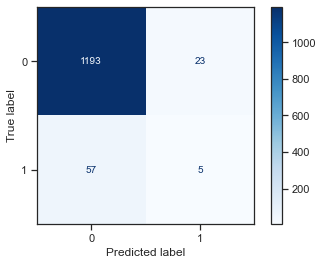

In [54]:
# Plot the confusion matrix
plot_confusion_matrix(bagged_tree_tuned, X_test, y_test, cmap = plt.cm.Blues);

**Random Forest Models**

In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss

# Build a baseline model and find the average cross-validated log loss
forest_baseline = RandomForestClassifier(random_state=42)
forest_neg_log_loss_cv = -cross_val_score(
    forest_baseline,
    X_train_resampled,
    y_train_resampled,
    scoring='neg_log_loss')
forest_neg_log_loss_cv.mean()

0.10219079597441016

In [56]:
# Evaluate the model
forest_baseline.fit(X_train_resampled, y_train_resampled)
preds = forest_baseline.predict(X_test)
print("Random Forest Baseline Model:")
print_metrics(y_test, preds)

Random Forest Baseline Model:
Accuracy Score: 0.931924882629108
Precision Score: 0.06896551724137931
Recall Score: 0.03225806451612903
F1 Score: 0.04395604395604396


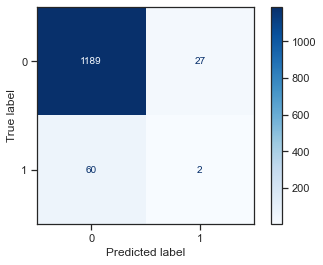

In [57]:
# Plot the confusion matrix
plot_confusion_matrix(forest_baseline, X_test, y_test, cmap = plt.cm.Blues);

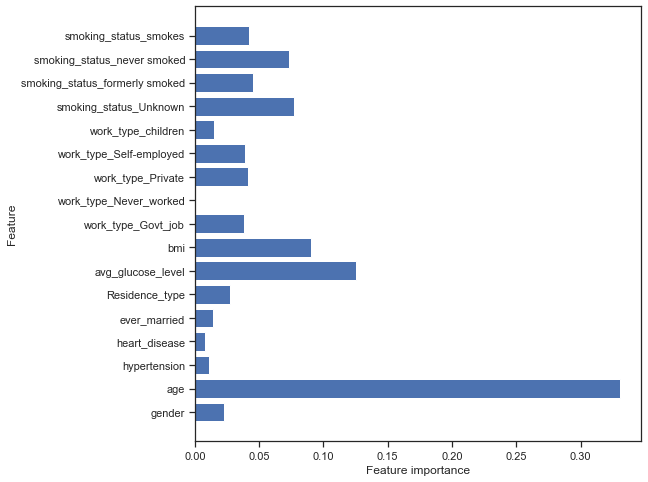

In [58]:
# Find out the importance of the features in the baseline model
plot_feature_importances(forest_baseline)

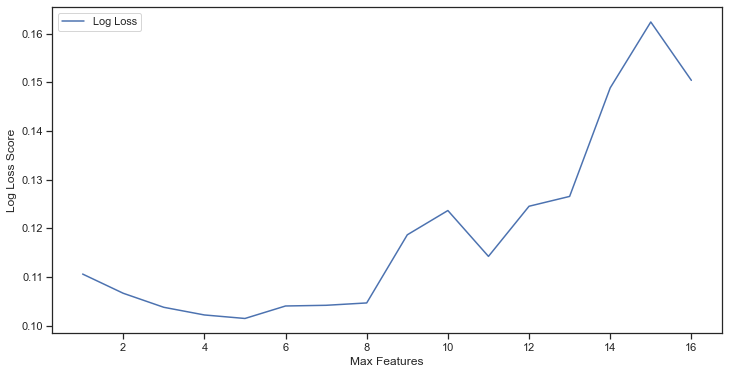

In [59]:
# Find the best value for max features
max_features = list(range(1, X_train_resampled.shape[1]))
log_loss_results = []
for max_feature in max_features:
    forest = RandomForestClassifier(random_state=42,
                                    max_features=max_feature)
    forest.fit(X_train_resampled, y_train_resampled)
    y_pred = forest.predict(X_test)
    forest_log_loss = cross_val_score(
        forest, 
        X_train_resampled,
        y_train_resampled,
        scoring='neg_log_loss')
    forestlog_loss = -(forest_log_loss.mean())
    log_loss_results.append(forestlog_loss)
    
plt.figure(figsize=(12,6))
plt.plot(max_features, log_loss_results, label='Log Loss')
plt.ylabel('Log Loss Score')
plt.xlabel("Max Features")
plt.legend()
plt.show()

In [60]:
# Run the optimized model
forest_tuned = RandomForestClassifier(random_state=42, max_features=5)
forest_tuned_neg_log_loss_cv = -cross_val_score(
    forest_tuned,
    X_train_resampled,
    y_train_resampled,
    scoring='neg_log_loss')
random_forest_log_loss = forest_tuned_neg_log_loss_cv.mean()
random_forest_log_loss

0.10146768346761763

In [62]:
# Evaluate the optimized model
forest_tuned.fit(X_train_resampled, y_train_resampled)
preds = forest_tuned.predict(X_test)
print("Random Forest Tuned Model:")
print_metrics(y_test, preds)

Random Forest Tuned Model:
Accuracy Score: 0.9366197183098591
Precision Score: 0.14814814814814814
Recall Score: 0.06451612903225806
F1 Score: 0.0898876404494382


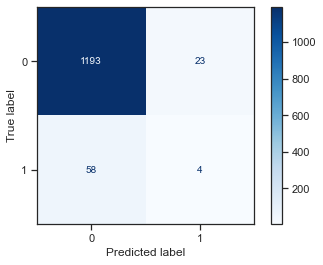

In [63]:
# Plot the confusion matrix
plot_confusion_matrix(forest_tuned, X_test, y_test, cmap = plt.cm.Blues);

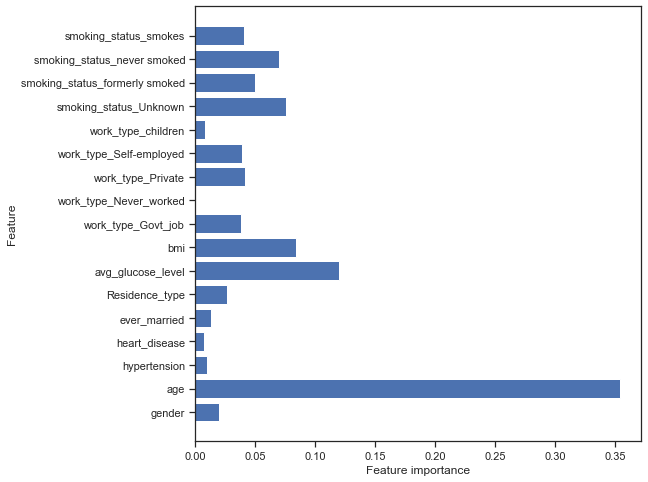

In [64]:
# Check the importance of features in the optimized model
plot_feature_importances(forest_tuned)

**AdaBoost Models**

In [65]:
from sklearn.ensemble import AdaBoostClassifier

# Build a baseline model and find the average cross-validated log loss
adaboost_baseline = AdaBoostClassifier(random_state=42)
adaboost_baseline_neg_log_loss_cv = -cross_val_score(
    adaboost_baseline,
    X_train_resampled,
    y_train_resampled,
    scoring='neg_log_loss')
adaboost_baseline_neg_log_loss_cv.mean()

0.6450623656872048

In [66]:
# Evaluate the model
adaboost_baseline.fit(X_train_resampled, y_train_resampled)
preds = adaboost_baseline.predict(X_test)
print("AdaBoost Baseline Model:")
print_metrics(y_test, preds)

AdaBoost Baseline Model:
Accuracy Score: 0.9045383411580594
Precision Score: 0.18085106382978725
Recall Score: 0.27419354838709675
F1 Score: 0.21794871794871798


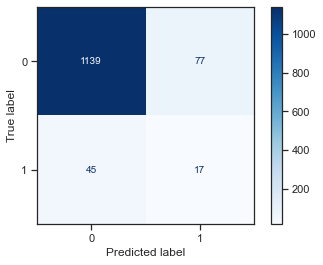

In [67]:
# Plot the confusion matrix
plot_confusion_matrix(adaboost_baseline, X_test, y_test, cmap = plt.cm.Blues);

In [68]:
# Use the Grid Search to fins the best learning rate
adaboost_tuned = AdaBoostClassifier(random_state=42)
param_grid = {'learning_rate' : [0.1, 0.2]}
    
grid_search = GridSearchCV(estimator = adaboost_tuned,
                           param_grid = param_grid,
                           cv = 3)
grid_search.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=3, estimator=AdaBoostClassifier(random_state=42),
             param_grid={'learning_rate': [0.1, 0.2]})

In [69]:
# Print the best parameters
grid_search.best_params_

{'learning_rate': 0.2}

In [70]:
# Run the optimized model to find the average cross-validated log loss
adaboost_tuned = AdaBoostClassifier(
    random_state=42,
    learning_rate=0.2)
adaboost_tuned_neg_log_loss_cv = -cross_val_score(
    adaboost_tuned,
    X_train_resampled,
    y_train_resampled,
    scoring='neg_log_loss')
adaboost_log_loss = adaboost_tuned_neg_log_loss_cv.mean()
adaboost_log_loss

0.6015339450980731

In [71]:
# Evaluate the model
adaboost_tuned.fit(X_train_resampled, y_train_resampled)
preds = adaboost_tuned.predict(X_test)
print("AdaBoost Tuned Model:")
print_metrics(y_test, preds)

AdaBoost Tuned Model:
Accuracy Score: 0.8082942097026604
Precision Score: 0.15471698113207547
Recall Score: 0.6612903225806451
F1 Score: 0.2507645259938838


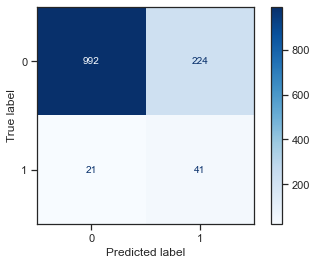

In [72]:
# Plot the confusion matrix
plot_confusion_matrix(adaboost_tuned, X_test, y_test, cmap = plt.cm.Blues);

**Gradient Boosting Models**

In [73]:
# Build a baseline model and find the average of the cross-validated log loss
from sklearn.ensemble import GradientBoostingClassifier
gbt_baseline = GradientBoostingClassifier(random_state=42)
gbt_baseline_neg_log_loss_cv = -cross_val_score(
    gbt_baseline,
    X_train_resampled,
    y_train_resampled,
    scoring='neg_log_loss')
gbt_baseline_neg_log_loss_cv.mean()

0.16693371512835395

In [74]:
# Evaluate the model
gbt_baseline.fit(X_train_resampled, y_train_resampled)
preds = gbt_baseline.predict(X_test)
print("Gradient Boosting Baseline Model:")
print_metrics(y_test, preds)

Gradient Boosting Baseline Model:
Accuracy Score: 0.9358372456964006
Precision Score: 0.3
Recall Score: 0.24193548387096775
F1 Score: 0.26785714285714285


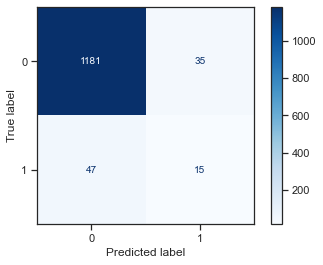

In [75]:
# Plot the confusion matrix
plot_confusion_matrix(gbt_baseline, X_test, y_test, cmap = plt.cm.Blues);

In [76]:
# Use the grid search to find the best learning rate
gbt = GradientBoostingClassifier(random_state=42)
param_grid = {'learning_rate' : [0.5, 0.7, 1.0]}
    
grid_search = GridSearchCV(estimator = gbt,
                           param_grid = param_grid,
                           cv = 3)
grid_search.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=42),
             param_grid={'learning_rate': [0.5, 0.7, 1.0]})

In [77]:
# Print the best parameter
grid_search.best_params_

{'learning_rate': 0.7}

In [78]:
# Run the optimized model
gbt_tuned = GradientBoostingClassifier(
    random_state=42,
    learning_rate=0.7)
gbt_tuned_neg_log_loss_cv = -cross_val_score(
    gbt_tuned,
    X_train_resampled,
    y_train_resampled,
    scoring='neg_log_loss')
gbt_log_loss = gbt_tuned_neg_log_loss_cv.mean()
gbt_log_loss

0.1706551756814217

In [79]:
# Evaluate the model
gbt_tuned.fit(X_train_resampled, y_train_resampled)
preds = gbt_tuned.predict(X_test)
print("Gradient Boosting Tuned Model:")
print_metrics(y_test, preds)

Gradient Boosting Tuned Model:
Accuracy Score: 0.9241001564945227
Precision Score: 0.14285714285714285
Recall Score: 0.11290322580645161
F1 Score: 0.12612612612612611


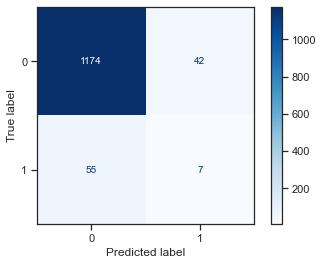

In [80]:
# Plot the confusion matrix
plot_confusion_matrix(gbt_tuned, X_test, y_test, cmap = plt.cm.Blues);

**XGBoost Models**

In [81]:
# Build and run a baseline model
from xgboost import XGBClassifier
xgb_baseline = XGBClassifier(random_state=42)
xgb_baseline_neg_log_loss_cv = -cross_val_score(
    xgb_baseline,
    X_train_resampled,
    y_train_resampled,
    scoring='neg_log_loss')
xgb_baseline_neg_log_loss_cv.mean()

0.1246033216933287

In [82]:
# Evaluate the model
xgb_baseline.fit(X_train_resampled, y_train_resampled)
preds = xgb_baseline.predict(X_test)
print("XGBoost Baseline Model:")
print_metrics(y_test, preds)

XGBoost Baseline Model:
Accuracy Score: 0.9389671361502347
Precision Score: 0.2647058823529412
Recall Score: 0.14516129032258066
F1 Score: 0.1875


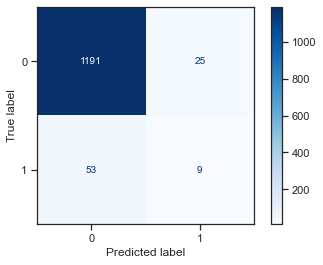

In [83]:
# Plot the confusion matrix
plot_confusion_matrix(xgb_baseline, X_test, y_test, cmap = plt.cm.Blues);

In [84]:
# Use the grid search to find the best hyperparameters
xgb = XGBClassifier(random_state=42)
param_grid = {'learning_rate' : [0.1, 0.2],
              'max_depth' : [6],
              'min_child_weight' : [1, 2],
              'subsample' : [0.5, 0.7],
              'n_estimators' : [100]}
    
grid_search = GridSearchCV(estimator = xgb,
                           param_grid = param_grid,
                           cv = 3)
grid_search.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=42,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, v

In [85]:
# Print the best hyperparameters
grid_search.best_params_

{'learning_rate': 0.2,
 'max_depth': 6,
 'min_child_weight': 2,
 'n_estimators': 100,
 'subsample': 0.7}

In [86]:
# Run the optimized model
xgb_tuned = XGBClassifier(random_state=42,
                          learning_rate=0.2,
                          max_depth=6,
                          min_child_weight=2,
                          n_estimators=100,
                          subsample=0.7)
xgb_tuned_neg_log_loss_cv = -cross_val_score(
    xgb_tuned,
    X_train_resampled,
    y_train_resampled,
    scoring='neg_log_loss')
xgb_log_loss = xgb_tuned_neg_log_loss_cv.mean()
xgb_log_loss

0.11903475070084428

In [87]:
# Evaluate the model
xgb_tuned.fit(X_train_resampled, y_train_resampled)
preds = xgb_tuned.predict(X_test)
print("XGBoost Tuned Model:")
print_metrics(y_test, preds)

XGBoost Tuned Model:
Accuracy Score: 0.9327073552425665
Precision Score: 0.18421052631578946
Recall Score: 0.11290322580645161
F1 Score: 0.14


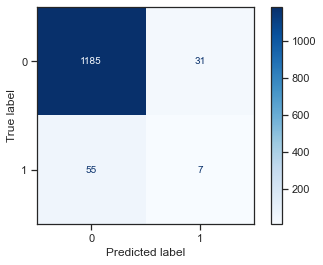

In [88]:
# Plot the confusion matrix
plot_confusion_matrix(xgb_tuned, X_test, y_test, cmap = plt.cm.Blues);

**Naive Bayes Models**

In [89]:
# Build a baseline model and find the average cross-validated log loss
from sklearn.naive_bayes import GaussianNB
naive_bayes_baseline = GaussianNB()
naive_bayes_baseline_neg_log_loss_cv = -cross_val_score(
    naive_bayes_baseline,
    X_train_resampled,
    y_train_resampled,
    scoring='neg_log_loss')
naive_bayes_baseline_neg_log_loss_cv.mean()

1.4229775321182352

In [90]:
# Evaluate the model
naive_bayes_baseline.fit(X_train_resampled, y_train_resampled)
preds = naive_bayes_baseline.predict(X_test)
print("Naive Bayes Baseline Model:")
print_metrics(y_test, preds)

Naive Bayes Baseline Model:
Accuracy Score: 0.5727699530516432
Precision Score: 0.0798611111111111
Recall Score: 0.7419354838709677
F1 Score: 0.14420062695924762


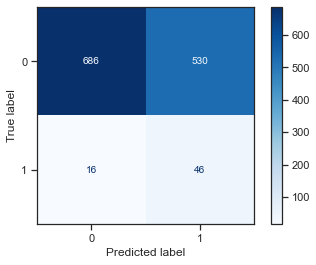

In [91]:
# Plot the confusion matrix
plot_confusion_matrix(naive_bayes_baseline, X_test, y_test, cmap = plt.cm.Blues);

In [92]:
# Find the best value for var_smoothing
nb = GaussianNB()
param_grid = {'var_smoothing' : np.logspace(0,-9, num=100)}
    
grid_search = GridSearchCV(estimator = nb,
                           param_grid = param_grid,
                           cv = 3)
grid_search.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=3, estimator=GaussianNB(),
             param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.51119173e-02, 2.84803587e-02, 2.31...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])})

In [93]:
# Print the best parameter
grid_search.best_params_

{'var_smoothing': 1.5199110829529332e-05}

In [94]:
# Run the optimized model
nb_tuned = GaussianNB(var_smoothing=1.52e-05)
nb_tuned_neg_log_loss_cv = -cross_val_score(
    nb_tuned,
    X_train_resampled,
    y_train_resampled,
    scoring='neg_log_loss')
nb_log_loss = nb_tuned_neg_log_loss_cv.mean()
nb_log_loss

0.4117644090138698

In [95]:
# Evaliuate the model
nb_tuned.fit(X_train_resampled, y_train_resampled)
preds = nb_tuned.predict(X_test)
print("Naive Bayes Tuned Model:")
print_metrics(y_test, preds)

Naive Bayes Tuned Model:
Accuracy Score: 0.7230046948356808
Precision Score: 0.11170212765957446
Recall Score: 0.6774193548387096
F1 Score: 0.1917808219178082


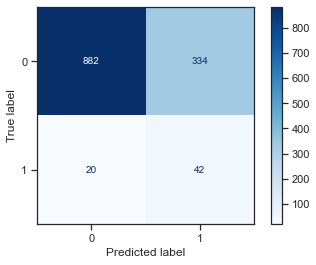

In [96]:
# Plot the confusion matrix
plot_confusion_matrix(nb_tuned, X_test, y_test, cmap = plt.cm.Blues);

In [97]:
# Instantiate StandardScaler and transform the variables
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

**KNN Models**

In [98]:
# Build a baseline model
from sklearn.neighbors import KNeighborsClassifier
knn_baseline = KNeighborsClassifier()
knn_baseline_log_loss = -cross_val_score(
    knn_baseline,
    X_train_scaled,
    y_train_resampled,
    scoring='neg_log_loss').mean()
knn_baseline_log_loss

0.7038958225329448

In [99]:
# Evaluate the model
knn_baseline.fit(X_train_scaled, y_train_resampled)
preds = knn_baseline.predict(X_test_scaled)
print("KNN Baseline Model:")
print_metrics(y_test, preds)

KNN Baseline Model:
Accuracy Score: 0.8990610328638498
Precision Score: 0.06493506493506493
Recall Score: 0.08064516129032258
F1 Score: 0.07194244604316546


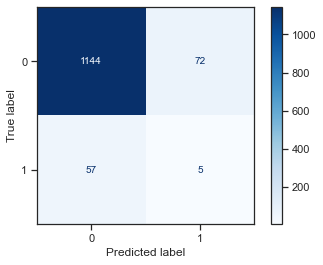

In [100]:
# Plot the confusion matrix
plot_confusion_matrix(knn_baseline, X_test_scaled, y_test, cmap = plt.cm.Blues);

In [101]:
# Change hyperparameter to see if the model performs any better
knn_first_model = KNeighborsClassifier(n_neighbors=90)
knn_first_log_loss = -cross_val_score(
    knn_first_model,
    X_train_scaled,
    y_train_resampled,
    scoring='neg_log_loss').mean()
knn_first_log_loss

0.24211022662260553

In [102]:
# Change hyperparameter and repeat the step above
knn_second_model = KNeighborsClassifier(n_neighbors=50)
knn_second_log_loss = -cross_val_score(
    knn_second_model,
    X_train_scaled,
    y_train_resampled,
    scoring='neg_log_loss').mean()
knn_second_log_loss

0.24322134202322693

In [103]:
# Write the funstion that finds the best value for n_neighbors
def find_best_k(X_train, y_train, X_test, y_test, min_k=50, max_k=90):
    best_k = 0
    best_score = 1.00
    for k in range(min_k, max_k+1, 2):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        preds = knn.predict(X_test)
        log_loss = -cross_val_score(
            knn,
            X_train,
            y_train, 
            scoring='neg_log_loss').mean()
        if log_loss < best_score:
            best_k = k
            best_score = log_loss
    print("Best Value for k: {}".format(best_k))
    print("Log Loss: {}".format(best_score))

In [104]:
# Find the best value of k for the model
find_best_k(X_train_scaled, y_train_resampled, X_test_scaled, y_test)

Best Value for k: 66
Log Loss: 0.23548341564709557


In [105]:
# Run the optimized model
knn_tuned = KNeighborsClassifier(n_neighbors=66)
knn_tuned_log_loss = -cross_val_score(
    knn_tuned,
    X_train_scaled,
    y_train_resampled,
    scoring='neg_log_loss').mean()
knn_log_loss = knn_tuned_log_loss
knn_log_loss

0.23548341564709557

In [108]:
# Evaluate the optimized model
knn_tuned.fit(X_train_scaled, y_train_resampled)
preds = knn_tuned.predict(X_test_scaled)
print("KNN Tuned Model:")
print_metrics(y_test, preds)

KNN Tuned Model:
Accuracy Score: 0.9147104851330203
Precision Score: 0.20253164556962025
Recall Score: 0.25806451612903225
F1 Score: 0.22695035460992907


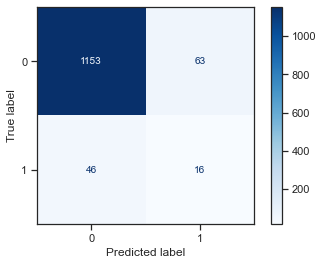

In [109]:
# Plot the confusion matrix
plot_confusion_matrix(knn_tuned, X_test_scaled, y_test, cmap = plt.cm.Blues);

**SVM Models**

In [110]:
# Build a baseline model
from sklearn.svm import SVC
svc_baseline = SVC(random_state=42, probability=True)
svc_baseline_log_loss = -cross_val_score(
    svc_baseline,
    X_train_scaled,
    y_train_resampled,
    scoring='neg_log_loss').mean()
svc_baseline_log_loss

0.174788274824406

In [111]:
# Evaluate the model
svc_baseline.fit(X_train_scaled, y_train_resampled)
preds = svc_baseline.predict(X_test_scaled)
print("SVM Baseline Model:")
print_metrics(y_test, preds)

SVM Baseline Model:
Accuracy Score: 0.9295774647887324
Precision Score: 0.15
Recall Score: 0.0967741935483871
F1 Score: 0.11764705882352941


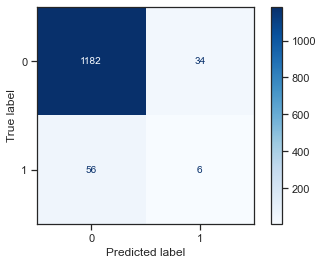

In [112]:
# Plot the confusion matrix
plot_confusion_matrix(svc_baseline, X_test_scaled, y_test, cmap = plt.cm.Blues);

In [113]:
# Find the best hyperparameters
svc = SVC(random_state=42, probability=True)
param_grid = {'C': [0.1, 1, 10],
              'gamma': [1, 0.1, 'auto']}
    
grid_search = GridSearchCV(estimator = svc,
                           param_grid = param_grid,
                           cv = 3)
grid_search.fit(X_train_scaled, y_train_resampled)

GridSearchCV(cv=3, estimator=SVC(probability=True, random_state=42),
             param_grid={'C': [0.1, 1, 10], 'gamma': [1, 0.1, 'auto']})

In [114]:
# Print the best hyperparameters
grid_search.best_params_

{'C': 1, 'gamma': 1}

In [115]:
# Run the optimized model
svc_tuned = SVC(random_state=42, probability=True, C=1, gamma=1)
svc_tuned_log_loss = -cross_val_score(
    svc_tuned,
    X_train_scaled,
    y_train_resampled,
    scoring='neg_log_loss').mean()
svc_log_loss = svc_tuned_log_loss
svc_log_loss

0.15432487883744125

In [116]:
# Evaluate the optimized model
svc_tuned.fit(X_train_scaled, y_train_resampled)
svc = svc_tuned.predict(X_test_scaled)
print("SVM Tuned Model:")
print_metrics(y_test, preds)

SVM Tuned Model:
Accuracy Score: 0.9295774647887324
Precision Score: 0.15
Recall Score: 0.0967741935483871
F1 Score: 0.11764705882352941


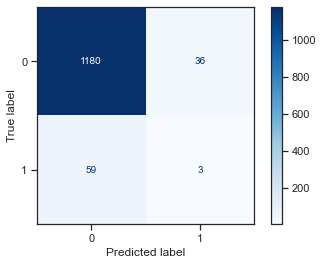

In [117]:
# Plot the confusion matrix
plot_confusion_matrix(svc_tuned, X_test_scaled, y_test, cmap = plt.cm.Blues);

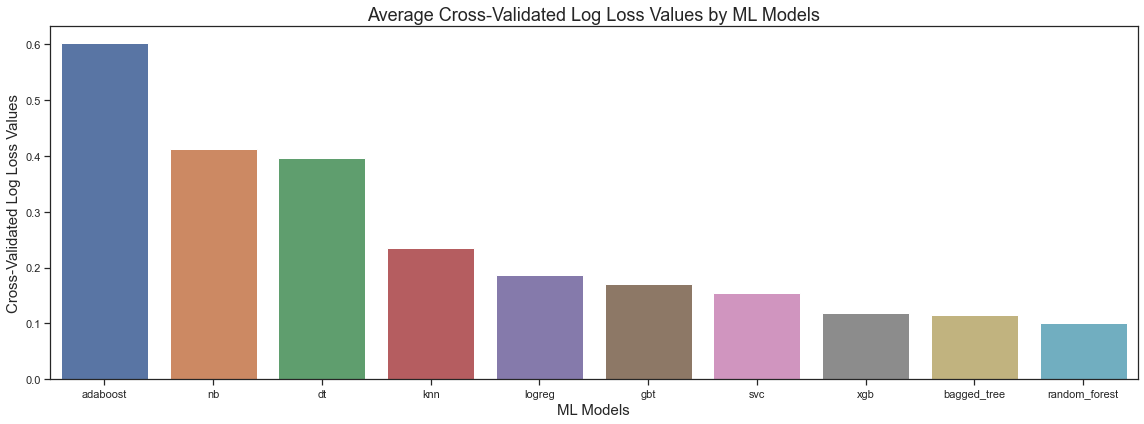

In [118]:
log_loss = [logreg_log_loss, dt_log_loss, bagged_tree_log_loss, 
            random_forest_log_loss, adaboost_log_loss, gbt_log_loss,
            xgb_log_loss, nb_log_loss, knn_log_loss, svc_log_loss]
logloss = [round(num, 3) for num in log_loss]
models = ['logreg', 'dt', 'bagged_tree', 'random_forest', 'adaboost',
          'gbt', 'xgb', 'nb', 'knn', 'svc']
df_log_loss = pd.DataFrame({'models': models, 'log_loss': logloss}).sort_values(
    'log_loss', ascending=False)
plt.figure(figsize=(16,6))
sns.barplot(x='models', y='log_loss', data=df_log_loss)
plt.xlabel("ML Models", size=15)
plt.ylabel("Cross-Validated Log Loss Values", size=15)
plt.title("Average Cross-Validated Log Loss Values by ML Models", size=18)
plt.tight_layout()
plt.savefig("Log-loss.png", dpi=100)

In [120]:
acc_logreg = accuracy_score(y_test, logreg_tuned.predict(X_test))
acc_logreg

0.9225352112676056

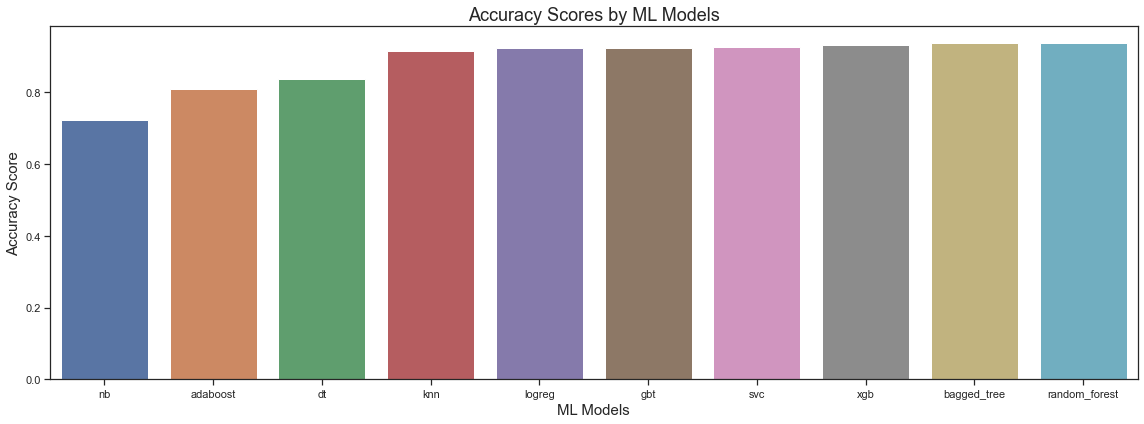

In [122]:
acc_logreg = accuracy_score(y_test, logreg_tuned.predict(X_test))
acc_dt = accuracy_score(y_test, dt_tuned.predict(X_test))
acc_bagged = accuracy_score(y_test, bagged_tree_tuned.predict(X_test))
acc_forest = accuracy_score(y_test, forest_tuned.predict(X_test))
acc_adaboost = accuracy_score(y_test, adaboost_tuned.predict(X_test))
acc_gbt = accuracy_score(y_test, gbt_tuned.predict(X_test))
acc_xgb = accuracy_score(y_test, xgb_tuned.predict(X_test))
acc_nb = accuracy_score(y_test, nb_tuned.predict(X_test))
acc_knn = accuracy_score(y_test, knn_tuned.predict(X_test_scaled))
acc_svc = accuracy_score(y_test, svc_tuned.predict(X_test_scaled))

accuracies = [acc_logreg, acc_dt, acc_bagged, acc_forest, acc_adaboost,
              acc_gbt, acc_xgb, acc_nb, acc_knn, acc_svc]
accuracy_score = [round(num, 3) for num in accuracies]

df_accuracy = pd.DataFrame({'models': models, 'accuracy': accuracy_score}).sort_values(
    'accuracy', ascending=True)
plt.figure(figsize=(16,6))
sns.barplot(x='models', y='accuracy', data=df_accuracy)
plt.xlabel("ML Models", size=15)
plt.ylabel("Accuracy Score", size=15)
plt.title("Accuracy Scores by ML Models", size=18)
plt.tight_layout()
plt.savefig("accuracy.png", dpi=100)

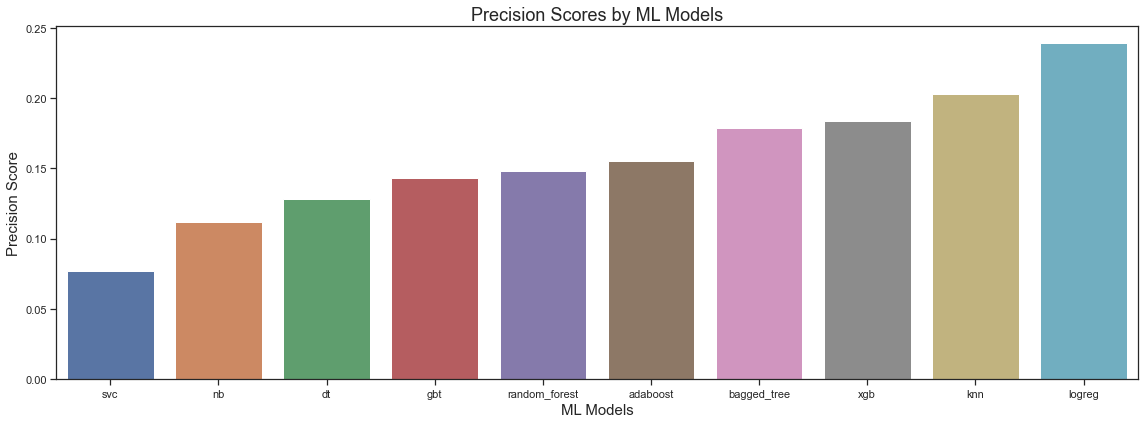

In [123]:
pre_logreg = precision_score(y_test, logreg_tuned.predict(X_test))
pre_dt = precision_score(y_test, dt_tuned.predict(X_test))
pre_bagged = precision_score(y_test, bagged_tree_tuned.predict(X_test))
pre_forest = precision_score(y_test, forest_tuned.predict(X_test))
pre_adaboost = precision_score(y_test, adaboost_tuned.predict(X_test))
pre_gbt = precision_score(y_test, gbt_tuned.predict(X_test))
pre_xgb = precision_score(y_test, xgb_tuned.predict(X_test))
pre_nb = precision_score(y_test, nb_tuned.predict(X_test))
pre_knn = precision_score(y_test, knn_tuned.predict(X_test_scaled))
pre_svc = precision_score(y_test, svc_tuned.predict(X_test_scaled))

precisions = [pre_logreg, pre_dt, pre_bagged, pre_forest, pre_adaboost,
              pre_gbt, pre_xgb, pre_nb, pre_knn, pre_svc]
precision_score = [round(num, 3) for num in precisions]

df_precision = pd.DataFrame({'models': models, 'precision': precision_score}).sort_values(
    'precision', ascending=True)
plt.figure(figsize=(16,6))
sns.barplot(x='models', y='precision', data=df_precision)
plt.xlabel("ML Models", size=15)
plt.ylabel("Precision Score", size=15)
plt.title("Precision Scores by ML Models", size=18)
plt.tight_layout()
plt.savefig("precision.png", dpi=100)

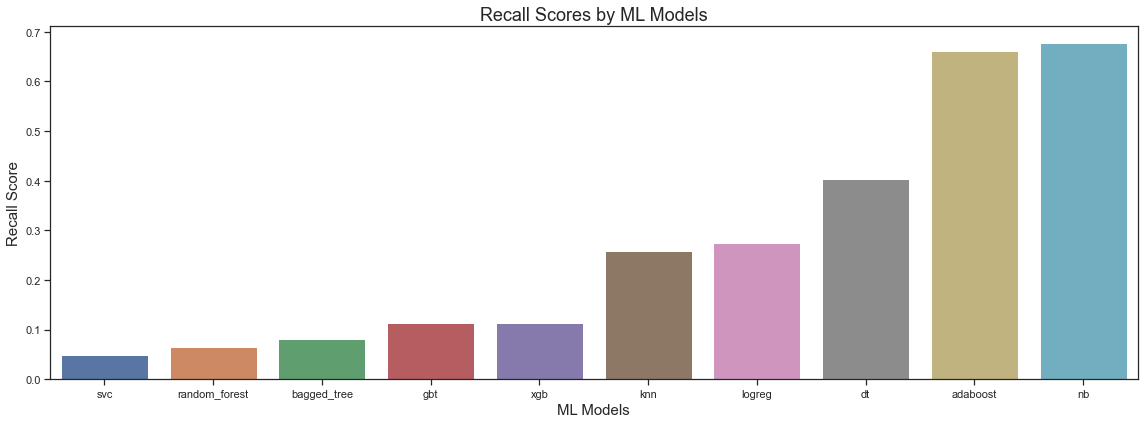

In [124]:
rec_logreg = recall_score(y_test, logreg_tuned.predict(X_test))
rec_dt = recall_score(y_test, dt_tuned.predict(X_test))
rec_bagged = recall_score(y_test, bagged_tree_tuned.predict(X_test))
rec_forest = recall_score(y_test, forest_tuned.predict(X_test))
rec_adaboost = recall_score(y_test, adaboost_tuned.predict(X_test))
rec_gbt = recall_score(y_test, gbt_tuned.predict(X_test))
rec_xgb = recall_score(y_test, xgb_tuned.predict(X_test))
rec_nb = recall_score(y_test, nb_tuned.predict(X_test))
rec_knn = recall_score(y_test, knn_tuned.predict(X_test_scaled))
rec_svc = recall_score(y_test, svc_tuned.predict(X_test_scaled))

recall = [rec_logreg, rec_dt, rec_bagged, rec_forest, rec_adaboost,
          rec_gbt, rec_xgb, rec_nb, rec_knn, rec_svc]
recall_score = [round(num, 3) for num in recall]

df_recall = pd.DataFrame({'models': models, 'recall': recall_score}).sort_values(
    'recall', ascending=True)
plt.figure(figsize=(16,6))
sns.barplot(x='models', y='recall', data=df_recall)
plt.xlabel("ML Models", size=15)
plt.ylabel("Recall Score", size=15)
plt.title("Recall Scores by ML Models", size=18)
plt.tight_layout()
plt.savefig("recall.png", dpi=100)

In [125]:
"""Since the business really cares about avoiding 'false negatives' more than avoiding 'false positives', the decision threshhold should be decreased, so recall can be increased"""

"Since the business really cares about avoiding 'false negatives' more than avoiding 'false positives', the decision threshhold should be decreased, so recall can be increased"

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

In [ ]:
threshold = 0.4

prodicted = random_forest_final.predict_proba(X_test)
predicted_stroke = (predicted[:,1] >= threshold).astype('int')


accuracy = accuracy_score(y_test, predicted_stroke)